## Import Functions, Modules

In [1]:
#import from my modules:
import src.als_model as am
from src.ensemble_helper_functions import merge_data, load_files
import src.rank_eval as rank_eval

In [2]:
#import from python modules:
import cPickle as pickle
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
#run dataprep script to prepare cleaned dataframe
import src.dataprep as dataprep

In [12]:
prep = dataprep.TrailDataPrep(dbname='mergeodb112417', host='localhost')
prep.init_psql_session()
prep.data_coll_query()
prep.create_df()
prep.col_cleaning()
prep.engr_features()
cleaned_df = prep.clean_dataset
with open ('../data/cleaned_df_24NOV17.pkl', 'w') as f:
    pickle.dump(cleaned_df, f)

## Open cleaned_df

In [13]:
with open ('../data/cleaned_df_24NOV17.pkl', 'rb') as f:
    cleaned_data = pickle.load(f)

In [14]:
cleaned_data['SeriesID'].unique()

array([ 2.,  1.,  3.,  0.,  4.])

## Instantiate Class Instances for ALS Model, Prep and Run for the Following:

#### For each of these features:
- SeriesID
- EventTypeID
- Venue (based on zip code)
- Total Average Fee
- Average Mileage

#### Run best fit model identified from exercise in Pipeline_v2-noTVS notebook on train+validate larger dataset; check rank metric on test set

#### Initial Prep:

In [15]:
als_model = am.implicit_als(cleaned_data, split_val=False)
#setting split_val to False results in the split being train/test instead of train/val/test
#80% of data is in train and 20% is in test

In [16]:
als_model.prep_full_df()

In [17]:
als_model.full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063176 entries, 0 to 1063175
Data columns (total 9 columns):
PersonID         1063176 non-null int64
EventID          1063176 non-null int64
Participated     1063176 non-null int64
Event_Date       1063176 non-null datetime64[ns]
SeriesID         1063176 non-null float64
EventTypeID      1063176 non-null int64
Total_Fee_Avg    1063176 non-null int64
Miles2_Avg       1063176 non-null int64
Venue_Zip        1063176 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 73.0 MB


In [18]:
als_model.train_val_test_split_byseries()

TrainVal Size: 850540.0
Train Size: 680432.0
Validation Size: 170108.0
Test Size: 212636.0


## SeriesID

In [19]:
als_model.print_train_val_test_info("SeriesID")

participants in train: 11432
participants in validate: 11432
participants in test: 11432


participants in both train & validate: 11432
participants in both train & test: 11432


SeriesID in train: 5
SeriesID in validate: 5
SeriesID in test: 5


SeriesID in both train & validate: 5
SeriesID in both train & test: 5


In [20]:
als_model.create_participate_matrices("SeriesID")

In [21]:
als_model.fit_ALS(itemCol="SeriesID", rank=5, alpha=80, coldStartStrategy="drop")

In [22]:
trainval_predictions, trainval_rank, trainval_pop_rank, test_predictions, test_rank, test_pop_rank = als_model.predict_ALS(
    als_model.base_model, "SeriesID")

Trainval predictions includes 850540 valid values and 0 nan values
Test predictions includes 212636 valid values and 0 nan values
Trainval Model Rank = 0.794387594977 and Popular Rank = 24.3500831947
Test Model Rank = 6.95878561323 and Popular Rank = 29.1822358346


In [23]:
als_fit_model_series = als_model.base_model
als_trainvalpreds_pd_series = trainval_predictions
als_testpreds_pd_series = test_predictions

als_fit_model_series.save("../model/als_fit_model_series")

with open ("../model/24NOV17_dbupdatemodels/als_trainvalpreds_pd_series.pkl", 'w') as f:
    pickle.dump(als_trainvalpreds_pd_series, f)
with open ('../model/24NOV17_dbupdatemodels/als_testpreds_pd_series.pkl', 'w') as f:
    pickle.dump(als_testpreds_pd_series, f)

In [24]:
#these only need to be saved once today:
als_trainval_df_pd = als_model.trainval
als_test_df_pd = als_model.test

In [25]:
with open ("../model/24NOV17_dbupdatemodels/als_trainval_df_pd.pkl", 'w') as f:
    pickle.dump(als_trainval_df_pd, f)
    
with open ("../model/24NOV17_dbupdatemodels/als_test_df_pd.pkl", 'w') as f:
    pickle.dump(als_test_df_pd, f)

## EventTypeID

In [26]:
als_model.print_train_val_test_info("EventTypeID")

participants in train: 11432
participants in validate: 11432
participants in test: 11432


participants in both train & validate: 11432
participants in both train & test: 11432


EventTypeID in train: 2
EventTypeID in validate: 2
EventTypeID in test: 2


EventTypeID in both train & validate: 2
EventTypeID in both train & test: 2


In [27]:
als_model.create_participate_matrices("EventTypeID")

In [28]:
als_model.fit_ALS(itemCol="EventTypeID", rank=30, alpha=80, coldStartStrategy="drop")

In [29]:
trainval_predictions, trainval_rank, trainval_pop_rank, test_predictions, test_rank, test_pop_rank = als_model.predict_ALS(
    als_model.base_model, "EventTypeID")

Trainval predictions includes 850540 valid values and 0 nan values
Test predictions includes 212636 valid values and 0 nan values
Trainval Model Rank = 0.00561139231486 and Popular Rank = 6.57570715474
Test Model Rank = 0.541979843155 and Popular Rank = 4.7932618683


In [30]:
als_fit_model_eventtype = als_model.base_model
als_trainvalpreds_pd_eventtype = trainval_predictions
als_testpreds_pd_eventtype = test_predictions

als_fit_model_eventtype.save("../model/als_fit_model_eventtype")

with open ("../model/24NOV17_dbupdatemodels/als_trainvalpreds_pd_eventtype.pkl", 'w') as f:
    pickle.dump(als_trainvalpreds_pd_eventtype, f)
with open ("../model/24NOV17_dbupdatemodels/als_testpreds_pd_eventtype.pkl", 'w') as f:
    pickle.dump(als_testpreds_pd_eventtype, f)

## Venue (Based on Zipcode)

In [31]:
als_model.print_train_val_test_info("Venue_Zip")

participants in train: 11432
participants in validate: 11432
participants in test: 11432


participants in both train & validate: 11432
participants in both train & test: 11432


Venue_Zip in train: 22
Venue_Zip in validate: 16
Venue_Zip in test: 14


Venue_Zip in both train & validate: 14
Venue_Zip in both train & test: 12


In [32]:
als_model.create_participate_matrices("Venue_Zip")

In [33]:
als_model.fit_ALS(itemCol="Venue_Zip", rank=5, alpha=80, coldStartStrategy="drop")

In [34]:
trainval_predictions, trainval_rank, trainval_pop_rank, test_predictions, test_rank, test_pop_rank = als_model.predict_ALS(
    als_model.base_model, "Venue_Zip")

Trainval predictions includes 850540 valid values and 0 nan values
Test predictions includes 189772 valid values and 0 nan values
Trainval Model Rank = 6.12124169947 and Popular Rank = 25.0532445923
Test Model Rank = 16.5762885588 and Popular Rank = 31.6396783432


In [35]:
als_fit_model_zipcode = als_model.base_model
als_trainvalpreds_pd_zipcode = trainval_predictions
als_testpreds_pd_zipcode = test_predictions

als_fit_model_zipcode.save("../model/als_fit_model_zipcode")

with open ("../model/24NOV17_dbupdatemodels/als_trainvalpreds_pd_zipcode.pkl", 'w') as f:
    pickle.dump(als_trainvalpreds_pd_zipcode, f)
with open ("../model/24NOV17_dbupdatemodels/als_testpreds_pd_zipcode.pkl", 'w') as f:
    pickle.dump(als_testpreds_pd_zipcode, f)

## Total Average Fee

In [36]:
als_model.print_train_val_test_info("Total_Fee_Avg")

participants in train: 11432
participants in validate: 11432
participants in test: 11432


participants in both train & validate: 11432
participants in both train & test: 11432


Total_Fee_Avg in train: 22
Total_Fee_Avg in validate: 11
Total_Fee_Avg in test: 10


Total_Fee_Avg in both train & validate: 8
Total_Fee_Avg in both train & test: 7


In [37]:
als_model.create_participate_matrices("Total_Fee_Avg")

In [38]:
als_model.fit_ALS(itemCol="Total_Fee_Avg", rank=5, alpha=80, coldStartStrategy="drop")

In [39]:
trainval_predictions, trainval_rank, trainval_pop_rank, test_predictions, test_rank, test_pop_rank = als_model.predict_ALS(
    als_model.base_model, "Total_Fee_Avg")

Trainval predictions includes 850540 valid values and 0 nan values
Test predictions includes 201204 valid values and 0 nan values
Trainval Model Rank = 6.95386835405 and Popular Rank = 25.2150415973
Test Model Rank = 16.0791487103 and Popular Rank = 26.7184782994


In [40]:
als_fit_model_avgfee = als_model.base_model
als_trainvalpreds_pd_avgfee = trainval_predictions
als_testpreds_pd_avgfee = test_predictions

als_fit_model_avgfee.save("../model/als_fit_model_avgfee")

with open ("../model/24NOV17_dbupdatemodels/als_trainvalpreds_pd_avgfee.pkl", 'w') as f:
    pickle.dump(als_trainvalpreds_pd_avgfee, f)

with open ("../model/24NOV17_dbupdatemodels/als_testpreds_pd_avgfee.pkl", 'w') as f:
    pickle.dump(als_testpreds_pd_avgfee, f)

## Average Mileage

In [41]:
als_model.print_train_val_test_info("Miles2_Avg")

participants in train: 11432
participants in validate: 11432
participants in test: 11432


participants in both train & validate: 11432
participants in both train & test: 11432


Miles2_Avg in train: 13
Miles2_Avg in validate: 10
Miles2_Avg in test: 10


Miles2_Avg in both train & validate: 8
Miles2_Avg in both train & test: 9


In [42]:
als_model.create_participate_matrices("Miles2_Avg")

In [43]:
als_model.fit_ALS(itemCol="Miles2_Avg", rank=5, alpha=80, coldStartStrategy="drop")

In [44]:
trainval_predictions, trainval_rank, trainval_pop_rank, test_predictions, test_rank, test_pop_rank = als_model.predict_ALS(
    als_model.base_model, "Miles2_Avg")

Trainval predictions includes 850540 valid values and 0 nan values
Test predictions includes 212636 valid values and 0 nan values
Trainval Model Rank = 3.46572593238 and Popular Rank = 22.7483083749
Test Model Rank = 12.3089540687 and Popular Rank = 21.5467075038


In [45]:
als_fit_model_avgmile = als_model.base_model
als_trainvalpreds_pd_avgmile = trainval_predictions
als_testpreds_pd_avgmile = test_predictions

als_fit_model_avgmile.save("../model/als_fit_model_avgmile")

with open ("../model/24NOV17_dbupdatemodels/als_trainvalpreds_pd_avgmile.pkl", 'w') as f:
    pickle.dump(als_trainvalpreds_pd_avgmile, f)
with open ("../model/24NOV17_dbupdatemodels/als_testpreds_pd_avgmile.pkl", 'w') as f:
    pickle.dump(als_testpreds_pd_avgmile, f)

## Build Gradient Boost Ensemble Using ALS Models Predictions as Inputs to Determine Weights for Each

#### Build X, y Train Matrices for GB Model; Split between Train and Validate

In [46]:
data_df = load_files('../model/24NOV17_dbupdatemodels/als_trainval_df_pd.pkl')
fee_preds = load_files('../model/24NOV17_dbupdatemodels/als_trainvalpreds_pd_avgfee.pkl')
mile_preds = load_files('../model/24NOV17_dbupdatemodels/als_trainvalpreds_pd_avgmile.pkl')
type_preds = load_files('../model/24NOV17_dbupdatemodels/als_trainvalpreds_pd_eventtype.pkl')
series_preds = load_files('../model/24NOV17_dbupdatemodels/als_trainvalpreds_pd_series.pkl')
zipcode_preds = load_files('../model/24NOV17_dbupdatemodels/als_trainvalpreds_pd_zipcode.pkl')

In [47]:
data_df['Event_Date'] = data_df['Event_Date'].astype('int64')//1e9

In [48]:
data_df['Event_Date'] = data_df['Event_Date'] * 1000000000

In [49]:
data_df.head()

,PersonID,EventID,Participated,Event_Date,SeriesID,EventTypeID,Total_Fee_Avg,Miles2_Avg,Venue_Zip
57160,1,13,0,1426291200000000000,0.0,1,37,8,98038
64775,7756,13,0,1426291200000000000,0.0,1,37,8,98038
64776,7757,13,0,1426291200000000000,0.0,1,37,8,98038
64777,7758,13,0,1426291200000000000,0.0,1,37,8,98038
64778,7759,13,0,1426291200000000000,0.0,1,37,8,98038


In [50]:
series_preds.head()

,PersonID,SeriesID,Participated,Event_Date,prediction
0,148,1.0,0,1420329600000000000,0.986585
1,148,1.0,0,1422057600000000000,0.986585
2,148,1.0,0,1423267200000000000,0.986585
3,148,1.0,1,1446854400000000000,0.986585
4,148,1.0,1,1448064000000000000,0.986585


In [51]:
predictions = [(series_preds, 'SeriesID'), (type_preds, 'EventTypeID'), 
               (zipcode_preds, 'Venue_Zip'), (fee_preds, 'Total_Fee_Avg'), 
               (mile_preds, 'Miles2_Avg')]

gb_train_data = data_df.copy()

for item in predictions:
    gb_train_data = merge_data(gb_train_data, item[0], item[1])

In [52]:
gb_train_data.sort_values(by='Event_Date', axis=0, ascending=True, inplace=True)

In [53]:
gb_train_data.reset_index(drop=True, inplace=True)

In [54]:
gb_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850540 entries, 0 to 850539
Data columns (total 9 columns):
PersonID                    850540 non-null int64
EventID                     850540 non-null int64
Participated                850540 non-null int64
Event_Date                  850540 non-null int64
SeriesID_prediction         850540 non-null float64
EventTypeID_prediction      850540 non-null float64
Venue_Zip_prediction        850540 non-null float64
Total_Fee_Avg_prediction    850540 non-null float64
Miles2_Avg_prediction       850540 non-null float64
dtypes: float64(5), int64(4)
memory usage: 58.4 MB


No NAN values to fill in since this is the predictions on the training data (no cold starts)

In [55]:
len(gb_train_data)*.8, len(gb_train_data)*.2

(680432.0, 170108.0)

Split data on first 680432 records for train (sorted by event_date as timestamp) and last 170108 records for test

In [56]:
X_gb_train = gb_train_data[['SeriesID_prediction', 'EventTypeID_prediction', 'Venue_Zip_prediction', 'Total_Fee_Avg_prediction', 
                      'Miles2_Avg_prediction']].iloc[:680432].copy()

In [57]:
y_gb_train = gb_train_data['Participated'].iloc[:680432].copy()

In [58]:
len(X_gb_train), len(y_gb_train)

(680432, 680432)

In [59]:
X_gb_val = gb_train_data[['SeriesID_prediction', 'EventTypeID_prediction', 'Venue_Zip_prediction', 'Total_Fee_Avg_prediction', 
                      'Miles2_Avg_prediction']].iloc[680432:].copy()

In [60]:
y_gb_val = gb_train_data['Participated'].iloc[680432:].copy()

In [61]:
len(X_gb_val), len(y_gb_val)

(170108, 170108)

In [62]:
with open('../model/24NOV17_dbupdatemodels/gb_train_data.pkl', 'w') as f:
    pickle.dump(gb_train_data, f)

#### Build X, y Test Matrices for GB Model

In [63]:
test_data_df = load_files('../model/24NOV17_dbupdatemodels/als_test_df_pd.pkl')
test_fee_preds = load_files('../model/24NOV17_dbupdatemodels/als_testpreds_pd_avgfee.pkl')
test_mile_preds = load_files('../model/24NOV17_dbupdatemodels/als_testpreds_pd_avgmile.pkl')
test_type_preds = load_files('../model/24NOV17_dbupdatemodels/als_testpreds_pd_eventtype.pkl')
test_series_preds = load_files('../model/24NOV17_dbupdatemodels/als_testpreds_pd_series.pkl')
test_zipcode_preds = load_files('../model/24NOV17_dbupdatemodels/als_testpreds_pd_zipcode.pkl')

In [64]:
test_data_df['Event_Date'] = test_data_df['Event_Date'].astype('int64')//1e9

In [65]:
test_data_df['Event_Date'] = test_data_df['Event_Date'] * 1000000000

In [66]:
test_predictions = [(test_series_preds, 'SeriesID'), (test_type_preds, 'EventTypeID'), 
               (test_zipcode_preds, 'Venue_Zip'), (test_fee_preds, 'Total_Fee_Avg'), 
               (test_mile_preds, 'Miles2_Avg')]

gb_test_data = test_data_df.copy()

for item in test_predictions:
    gb_test_data = merge_data(gb_test_data, item[0], item[1])

In [67]:
gb_test_data.sort_values(by='Event_Date', axis=0, ascending=True, inplace=True)

In [68]:
gb_test_data.reset_index(drop=True, inplace=True)

In [69]:
gb_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212636 entries, 0 to 212635
Data columns (total 9 columns):
PersonID                    212636 non-null int64
EventID                     212636 non-null int64
Participated                212636 non-null int64
Event_Date                  212636 non-null int64
SeriesID_prediction         212636 non-null float64
EventTypeID_prediction      212636 non-null float64
Venue_Zip_prediction        189772 non-null float64
Total_Fee_Avg_prediction    201204 non-null float64
Miles2_Avg_prediction       212636 non-null float64
dtypes: float64(5), int64(4)
memory usage: 14.6 MB


In [70]:
#need to fill nan values for and Fee and Mile Predictions (caused by cold starts during ALS modeling)
gb_test_data['Total_Fee_Avg_prediction'] = gb_test_data['Total_Fee_Avg_prediction'].apply(
                            lambda x: gb_test_data['Total_Fee_Avg_prediction'].mean() if pd.isnull(x) else x)
gb_test_data['Miles2_Avg_prediction'] = gb_test_data['Miles2_Avg_prediction'].apply(
                            lambda x: gb_test_data['Miles2_Avg_prediction'].mean() if pd.isnull(x) else x)
gb_test_data['Venue_Zip_prediction'] = gb_test_data['Venue_Zip_prediction'].apply(
                            lambda x: gb_test_data['Venue_Zip_prediction'].mean() if pd.isnull(x) else x)

In [71]:
gb_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212636 entries, 0 to 212635
Data columns (total 9 columns):
PersonID                    212636 non-null int64
EventID                     212636 non-null int64
Participated                212636 non-null int64
Event_Date                  212636 non-null int64
SeriesID_prediction         212636 non-null float64
EventTypeID_prediction      212636 non-null float64
Venue_Zip_prediction        212636 non-null float64
Total_Fee_Avg_prediction    212636 non-null float64
Miles2_Avg_prediction       212636 non-null float64
dtypes: float64(5), int64(4)
memory usage: 14.6 MB


In [72]:
X_gb_test = gb_test_data[['SeriesID_prediction', 'EventTypeID_prediction', 'Venue_Zip_prediction', 'Total_Fee_Avg_prediction', 
                      'Miles2_Avg_prediction']].copy()

In [73]:
y_gb_test = gb_test_data['Participated'].copy()

In [74]:
len(X_gb_test), len(y_gb_test)

(212636, 212636)

In [75]:
with open('../model/24NOV17_dbupdatemodels/gb_test_data.pkl', 'w') as f:
    pickle.dump(gb_test_data, f)

## Fit selected model with train+val data (using params tuned in previous DB runs):

In [76]:
X_gb_trainval = gb_train_data[['SeriesID_prediction', 'EventTypeID_prediction', 'Venue_Zip_prediction', 'Total_Fee_Avg_prediction', 
                      'Miles2_Avg_prediction']]

In [77]:
y_gb_trainval = gb_train_data['Participated']

In [78]:
gb_model_final = GradientBoostingRegressor(loss='ls', learning_rate=.01, n_estimators=100, subsample=0.5, max_depth=3)

In [79]:
gb_model_final.fit(X_gb_trainval, y_gb_trainval)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=0.5, verbose=0, warm_start=False)

In [80]:
gb_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212636 entries, 0 to 212635
Data columns (total 9 columns):
PersonID                    212636 non-null int64
EventID                     212636 non-null int64
Participated                212636 non-null int64
Event_Date                  212636 non-null int64
SeriesID_prediction         212636 non-null float64
EventTypeID_prediction      212636 non-null float64
Venue_Zip_prediction        212636 non-null float64
Total_Fee_Avg_prediction    212636 non-null float64
Miles2_Avg_prediction       212636 non-null float64
dtypes: float64(5), int64(4)
memory usage: 14.6 MB


In [81]:
gb_testpreds_final = gb_model_final.predict(X_gb_test)

In [82]:
len(gb_testpreds_final)

212636

In [83]:
len(y_gb_test)

212636

In [84]:
len(gb_test_data)

212636

In [85]:
rankeval_testpreds_df_final = pd.DataFrame({'PersonID': gb_test_data['PersonID'], 'EventID': 
                                      gb_test_data['EventID'], 'Participated': y_gb_test.values, 
                                      'prediction': gb_testpreds_final})

In [86]:
rankeval_testpreds_df_final.head()

,EventID,Participated,PersonID,prediction
0,1009,0,3369,0.006401
1,1009,0,5447,0.326017
2,1009,1,5448,0.326017
3,1009,0,5449,0.326017
4,1009,0,5450,0.326017


In [87]:
rank_processing_final = rank_eval.RankEval(rankeval_testpreds_df_final, 'PersonID', 'EventID', 'Participated', 'prediction')

In [88]:
rank_processing_final.calc_test_rank()

25.235657190454202

In [89]:
rank_processing_final.calc_popular_rank()

36.314446145992726

In [90]:
gb_trainvalpreds_final = gb_model_final.predict(X_gb_trainval)

In [91]:
len(gb_trainvalpreds_final)

850540

In [92]:
len(y_gb_trainval)

850540

In [93]:
len(gb_train_data)

850540

In [94]:
rankeval_trainvalpreds_df_final = pd.DataFrame({'PersonID': gb_train_data['PersonID'], 'EventID': 
                                      gb_train_data['EventID'], 'Participated': y_gb_trainval.values, 
                                      'prediction': gb_trainvalpreds_final})

In [95]:
rank_processing_final_train = rank_eval.RankEval(rankeval_trainvalpreds_df_final, 'PersonID', 'EventID', 'Participated', 'prediction')

In [96]:
rank_processing_final_train.calc_test_rank()

10.482894473985509

In [97]:
rank_processing_final_train.calc_popular_rank()

32.646627914514013

In [98]:
gb_model_final.get_params()

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': None,
 'subsample': 0.5,
 'verbose': 0,
 'warm_start': False}

In [99]:
zip(gb_model_final.feature_importances_, X_gb_train.columns.values)

[(0.18271412404843546, 'SeriesID_prediction'),
 (0.0097170459001578863, 'EventTypeID_prediction'),
 (0.29017844459493408, 'Venue_Zip_prediction'),
 (0.33103659557228743, 'Total_Fee_Avg_prediction'),
 (0.18635378988418516, 'Miles2_Avg_prediction')]

In [100]:
with open ('../model/gb_model_final', 'w') as f:
    pickle.dump(gb_model_final, f)
with open ('../model/gb_testpreds_final', 'w') as f:
    pickle.dump(gb_testpreds_final, f)

## Gather Info on Top Events and Likely Participants from Top 5 Recommendations Info for Each Person

In [102]:
with open ('../model/gb_testpreds_final', 'rb') as f:
    gb_testpreds_final = pickle.load(f)
with open ('../model/24NOV17_dbupdatemodels/gb_test_data.pkl', 'rb') as f:
    gb_test_data = pickle.load(f)
with open ('../model/24NOV17_dbupdatemodels/gb_train_data.pkl', 'rb') as f:
    gb_train_data = pickle.load(f)

In [103]:
with open ('../data/cleaned_df_24NOV17.pkl', 'rb') as f:
    cleaned_data = pickle.load(f)

In [104]:
rankeval_testpreds_df_final = pd.DataFrame({'PersonID': gb_test_data['PersonID'], 'EventID': 
                                      gb_test_data['EventID'], 'Participated': gb_test_data['Participated'], 
                                      'prediction': gb_testpreds_final})

In [105]:
D_topeventcounts = defaultdict(int)
D_likelyusers = defaultdict(list)

for person in rankeval_testpreds_df_final['PersonID'].unique():
    temp_df = rankeval_testpreds_df_final[rankeval_testpreds_df_final["PersonID"] == person].copy()
    temp_df.sort_values('prediction', ascending=False, inplace=True)
    temp_df = temp_df.iloc[:5]
    
    for event in temp_df['EventID'].values:
        D_topeventcounts[event] += 1
        D_likelyusers[event].append(person)

In [106]:
D_topeventcounts
#Number of instances that an event in the test dataset shows up in a person's top 10 recommendations

defaultdict(int,
            {63: 755,
             64: 3906,
             66: 3173,
             67: 2635,
             76: 1006,
             78: 1489,
             79: 1463,
             80: 1720,
             81: 1535,
             82: 3346,
             83: 3799,
             84: 2529,
             85: 814,
             86: 1946,
             87: 6313,
             88: 6580,
             89: 1567,
             1009: 2422,
             1010: 4877,
             1018: 4609,
             4003: 676})

In [107]:
topevents_df = pd.DataFrame({'EventID': D_topeventcounts.keys(), 'Count in Top 5s': D_topeventcounts.values()})

In [108]:
topevents_df = pd.merge(topevents_df, cleaned_data, on='EventID')

In [109]:
topevents_df = topevents_df[['Count in Top 5s', 'EventID', 'Total fee', 'Event_Name', 'Event_Date', 'MergeoEvent', 
                            'EventType', 'SeriesID', 'Miles2', 'Venue_Zip']]

In [110]:
D_avgfees = defaultdict(float)

idx = topevents_df.groupby('EventID')['Total fee'].mean().index.values
vals = topevents_df.groupby('EventID')['Total fee'].mean().values

for idx, val in zip(idx, vals):
    D_avgfees[idx] = round(val, 2)

In [111]:
D_avgmiles = defaultdict(float)

idx = topevents_df.groupby('EventID')['Miles2'].mean().index.values
vals = topevents_df.groupby('EventID')['Miles2'].mean().values

for idx, val in zip(idx, vals):
    D_avgmiles[idx] = round(val, 2)

In [112]:
topevents_df['Total fee'] = topevents_df['EventID'].apply(lambda x: D_avgfees[x])
topevents_df['Miles2'] = topevents_df['EventID'].apply(lambda x: D_avgmiles[x])

In [113]:
topevents_df.drop_duplicates(subset='EventID', inplace=True)

In [114]:
topevents_df.sort_values(by='Count in Top 5s', ascending=False, inplace=True)
topevents_df.reset_index(drop=True, inplace = True)
topevents_df

#Not much trend showing up in top recommended events with regard to fee, miles, venue zips, event date....a little series
#try changing miles ALS to # of distance options at race rather than average mileage for race

,Count in Top 5s,EventID,Total fee,Event_Name,Event_Date,MergeoEvent,EventType,SeriesID,Miles2,Venue_Zip
0,6580,88,33.68,Run With the Kokanee,2017-10-14,True,Trail Run,0.0,4.39,98027
1,6313,87,38.81,St Edward Harvest Half,2017-10-07,True,Trail Run,2.0,9.11,98028
2,4877,1010,38.51,Everett Scramble 2016,2016-07-24,True,Street Scramble,4.0,8.00,98208
3,4609,1018,27.34,Fremont Street Scramble 2017,2017-09-24,True,Street Scramble,4.0,8.00,98103
4,3906,64,33.94,Absolution Run,2017-01-01,True,Trail Run,1.0,5.16,98028
5,3799,83,46.28,Summer Blast,2017-08-19,True,Trail Run,2.0,12.49,98053
6,3346,82,38.51,Summer Eddy,2017-08-08,True,Trail Run,3.0,5.51,98028
7,3173,66,38.05,Frost Eagle,2017-01-21,True,Trail Run,1.0,8.22,98074
8,2635,67,29.61,Interlaken Icicle Dash,2017-02-05,True,Trail Run,1.0,4.35,98102
9,2529,84,30.28,Interlaken Ice Cream Dash,2017-08-22,True,Trail Run,3.0,4.19,98102


In [115]:
topevents_snapshot = topevents_df[['Count in Top 5s', 'Event_Name', 'EventType', 'SeriesID']].iloc[:10]
topevents_snapshot

,Count in Top 5s,Event_Name,EventType,SeriesID
0,6580,Run With the Kokanee,Trail Run,0.0
1,6313,St Edward Harvest Half,Trail Run,2.0
2,4877,Everett Scramble 2016,Street Scramble,4.0
3,4609,Fremont Street Scramble 2017,Street Scramble,4.0
4,3906,Absolution Run,Trail Run,1.0
5,3799,Summer Blast,Trail Run,2.0
6,3346,Summer Eddy,Trail Run,3.0
7,3173,Frost Eagle,Trail Run,1.0
8,2635,Interlaken Icicle Dash,Trail Run,1.0
9,2529,Interlaken Ice Cream Dash,Trail Run,3.0


In [116]:
topevents_snapshot['Attendance'] = [217,173,86,134,203,230,85,231,265,111]
topevents_snapshot.rename(columns={'Count in Top 5s' : 'Top5_Rec'}, inplace=True)
topevents_snapshot

,Top5_Rec,Event_Name,EventType,SeriesID,Attendance
0,6580,Run With the Kokanee,Trail Run,0.0,217
1,6313,St Edward Harvest Half,Trail Run,2.0,173
2,4877,Everett Scramble 2016,Street Scramble,4.0,86
3,4609,Fremont Street Scramble 2017,Street Scramble,4.0,134
4,3906,Absolution Run,Trail Run,1.0,203
5,3799,Summer Blast,Trail Run,2.0,230
6,3346,Summer Eddy,Trail Run,3.0,85
7,3173,Frost Eagle,Trail Run,1.0,231
8,2635,Interlaken Icicle Dash,Trail Run,1.0,265
9,2529,Interlaken Ice Cream Dash,Trail Run,3.0,111


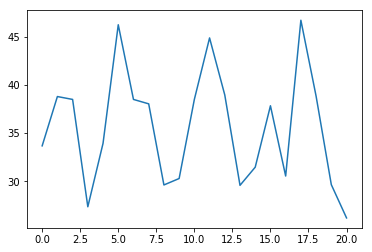

In [117]:
plt.plot(topevents_df.index.values, topevents_df['Total fee'])

In [118]:
D_likelyusers[81][:10]
#PersonIDs for which the given EventID is in their Top 10 recommendations

[3369, 5371, 5370, 5369, 5368, 5354, 5357, 5358, 5366, 5339]

In [119]:
likelyusers_event81_df = pd.DataFrame({'EventID': 81, 'PersonID': D_likelyusers[81]})
likelyusers_event81_df.head()

,EventID,PersonID
0,81,3369
1,81,5371
2,81,5370
3,81,5369
4,81,5368


In [120]:
likelyusers_event81_df = pd.merge(likelyusers_event81_df, cleaned_data, on='PersonID')

In [121]:
likelyusers_event81_df = likelyusers_event81_df[['PersonID', 'Gender', 'Age2', 'Zip Code', 'EventID_x']]

In [122]:
likelyusers_event81_df.drop_duplicates(subset='PersonID', inplace=True)

In [123]:
likelyusers_event81_df.head()

,PersonID,Gender,Age2,Zip Code,EventID_x
0,3369,Female,27.0,98272,81
1,5371,Male,43.0,98203,81
3,5370,Female,13.0,98203,81
4,5369,Female,15.0,98203,81
5,5368,Male,33.0,98105,81


In [124]:
tot_recs = float(len(likelyusers_event81_df))
print('Number of Top 5 Recommendations Users for Event 81, Seward Sizzler: {}'.format(tot_recs))

Number of Top 5 Recommendations Users for Event 81, Seward Sizzler: 1535.0


In [125]:
print('Percent Male/Female Recommended for Race 81, Seward Sizzler: {}, {}'.format(
    (likelyusers_event81_df[likelyusers_event81_df['Gender'] == 'Male'].count()['PersonID'])/tot_recs, 
    (likelyusers_event81_df[likelyusers_event81_df['Gender'] == 'Female'].count()['PersonID'])/tot_recs))

Percent Male/Female Recommended for Race 81, Seward Sizzler: 0.407817589577, 0.591530944625


In [126]:
tot_males = float(cleaned_data[cleaned_data['Gender'] == 'Male'].drop_duplicates('PersonID').count()['PersonID'])
tot_males

4831.0

In [127]:
tot_females = float(cleaned_data[cleaned_data['Gender'] == 'Female'].drop_duplicates('PersonID').count()['PersonID'])
tot_females

6584.0

In [128]:
print('Percent Male/Female in Total Population: {}, {}'.format(
    (tot_males / (tot_males+tot_females)), (tot_females / (tot_males+tot_females))))

Percent Male/Female in Total Population: 0.423215067893, 0.576784932107


In [129]:
print('Average Age Recommended for Race 81, Seward Sizzler: {}'.format(
    round(likelyusers_event81_df['Age2'].mean(), 1)))

Average Age Recommended for Race 81, Seward Sizzler: 36.5


In [130]:
print('Average Age in Total Population: {}'.format(
    round(cleaned_data['Age2'].mean(), 1)))

Average Age in Total Population: 37.5


## Ensemble rank score is worse than each individual ALS model's score from the test set:

#### Try a naive approach to ensembling, just averaging the input predictions from each ALS for each person to compare that score to the GB score

#### On Train Data:

In [131]:
gb_train_data.head()

,PersonID,EventID,Participated,Event_Date,SeriesID_prediction,EventTypeID_prediction,Venue_Zip_prediction,Total_Fee_Avg_prediction,Miles2_Avg_prediction
0,5874,1000,0,1418428800000000000,0.470018,0.015024,0.266885,0.088532,0.555531
1,39,1000,0,1418428800000000000,0.404141,0.015024,0.000000,0.058609,0.841624
2,21,1000,0,1418428800000000000,0.000000,0.015024,0.240322,0.605235,0.958565
3,20,1000,0,1418428800000000000,0.000000,0.015024,0.240322,0.605235,0.958565
4,19,1000,0,1418428800000000000,0.006665,0.025066,0.074570,1.252837,0.959238


In [132]:
naive_train_ensemble = gb_train_data.copy()

In [133]:
naive_train_ensemble['prediction'] = (naive_train_ensemble['SeriesID_prediction'] +
                                      naive_train_ensemble['EventTypeID_prediction'] +
                                      naive_train_ensemble['Venue_Zip_prediction'] +
                                      naive_train_ensemble['Total_Fee_Avg_prediction'] +
                                      naive_train_ensemble['Miles2_Avg_prediction']) / 5.

In [134]:
naive_train_ensemble.drop(['Event_Date', 'SeriesID_prediction', 'EventTypeID_prediction', 'Venue_Zip_prediction', 
                          'Total_Fee_Avg_prediction', 'Miles2_Avg_prediction'], axis=1, inplace=True)

In [135]:
naive_train_ensemble.head()

,PersonID,EventID,Participated,prediction
0,5874,1000,0,0.279198
1,39,1000,0,0.263880
2,21,1000,0,0.363829
3,20,1000,0,0.363829
4,19,1000,0,0.463675


In [136]:
rank_processing_naive_train = rank_eval.RankEval(naive_train_ensemble, 'PersonID', 'EventID', 'Participated', 'prediction')

In [137]:
rank_processing_naive_train.calc_test_rank()

1.9336719881953728

In [138]:
rank_processing_naive_train.calc_popular_rank()

32.646627914514013

#### On Test Data:

In [139]:
gb_test_data.head()

,PersonID,EventID,Participated,Event_Date,SeriesID_prediction,EventTypeID_prediction,Venue_Zip_prediction,Total_Fee_Avg_prediction,Miles2_Avg_prediction
0,3369,1009,0,1464393600000000000,0.000000,0.015024,0.296258,0.180767,0.196521
1,5447,1009,0,1464393600000000000,0.983522,1.003753,1.304153,0.970284,0.971113
2,5448,1009,1,1464393600000000000,0.983522,1.003753,1.304153,0.970284,0.971113
3,5449,1009,0,1464393600000000000,0.974710,0.997568,1.278995,0.955265,0.958565
4,5450,1009,0,1464393600000000000,0.974710,0.997568,1.278995,0.955265,0.958565


In [140]:
naive_test_ensemble = gb_test_data.copy()

In [141]:
naive_test_ensemble['prediction'] = (naive_test_ensemble['SeriesID_prediction'] +
                                     naive_test_ensemble['EventTypeID_prediction'] +
                                      naive_test_ensemble['Venue_Zip_prediction'] +
                                      naive_test_ensemble['Total_Fee_Avg_prediction'] +
                                      naive_test_ensemble['Miles2_Avg_prediction']) / 5.

In [142]:
naive_test_ensemble.drop(['Event_Date', 'SeriesID_prediction', 'EventTypeID_prediction', 'Venue_Zip_prediction', 
                          'Total_Fee_Avg_prediction', 'Miles2_Avg_prediction'], axis=1, inplace=True)

In [143]:
naive_test_ensemble.head()

,PersonID,EventID,Participated,prediction
0,3369,1009,0,0.137714
1,5447,1009,0,1.046565
2,5448,1009,1,1.046565
3,5449,1009,0,1.033020
4,5450,1009,0,1.033020


In [144]:
rank_processing_naive_test = rank_eval.RankEval(naive_test_ensemble, 'PersonID', 'EventID', 'Participated', 'prediction')

In [145]:
rank_processing_naive_test.calc_test_rank()

53.668993776795205

In [146]:
rank_processing_naive_test.calc_popular_rank()

36.314446145992726

### Try another naive approach but only using the best two predictions from the set of five for each record (on test data)

In [147]:
naive_test_ensemble_top2 = gb_test_data.copy()

In [153]:
naive_test_ensemble_top2.iloc[0]

PersonID                    3.369000e+03
EventID                     1.009000e+03
Participated                0.000000e+00
Event_Date                  1.464394e+18
SeriesID_prediction         0.000000e+00
EventTypeID_prediction      1.502426e-02
Venue_Zip_prediction        2.962577e-01
Total_Fee_Avg_prediction    1.807667e-01
Miles2_Avg_prediction       1.965215e-01
Name: 0, dtype: float64

In [ ]:
import heapq
>>> import random
>>> x = range(100000)
>>> random.shuffle(x)
>>> heapq.nlargest(2, x)

In [154]:
import heapq

In [155]:
test = [naive_test_ensemble_top2.iloc[0]['SeriesID_prediction'], naive_test_ensemble_top2.iloc[0]['EventTypeID_prediction']]

In [156]:
heapq.nlargest(2,test)

[0.015024255961179733, 0.0]

In [162]:
naive_test_ensemble_top2['top2_preds'] = naive_test_ensemble_top2[['SeriesID_prediction','EventTypeID_prediction',
                                                                   'Venue_Zip_prediction','Total_Fee_Avg_prediction',
                                                                   'Miles2_Avg_prediction','Participated']].apply(
                        lambda row: heapq.nlargest(2,[row[0],row[1],row[2],row[3],row[4]])
                        if row[5] == 1 
                        else heapq.nsmallest(2,[row[0],row[1],row[2],row[3],row[4]]), axis=1)

In [163]:
naive_test_ensemble_top2.head()

,PersonID,EventID,Participated,Event_Date,SeriesID_prediction,EventTypeID_prediction,Venue_Zip_prediction,Total_Fee_Avg_prediction,Miles2_Avg_prediction,top2_preds
0,3369,1009,0,1464393600000000000,0.000000,0.015024,0.296258,0.180767,0.196521,"[0.0, 0.0150242559612]"
1,5447,1009,0,1464393600000000000,0.983522,1.003753,1.304153,0.970284,0.971113,"[0.970284044743, 0.971113145351]"
2,5448,1009,1,1464393600000000000,0.983522,1.003753,1.304153,0.970284,0.971113,"[1.30415284634, 1.00375282764]"
3,5449,1009,0,1464393600000000000,0.974710,0.997568,1.278995,0.955265,0.958565,"[0.955264687538, 0.958564639091]"
4,5450,1009,0,1464393600000000000,0.974710,0.997568,1.278995,0.955265,0.958565,"[0.955264687538, 0.958564639091]"


In [172]:
naive_test_ensemble_top2['prediction'] = naive_test_ensemble_top2[['top2_preds']].apply(lambda row: sum(row[0])/2., axis=1)

In [173]:
rank_processing_naive_test_top2 = rank_eval.RankEval(naive_test_ensemble_top2, 'PersonID', 'EventID', 'Participated', 'prediction')

In [174]:
rank_processing_naive_test_top2.calc_test_rank()

2.5949675714037488

In [175]:
rank_processing_naive_test_top2.calc_popular_rank()

36.314446145992726

## Make new predictions using this model instead!!